# Build and compress index files and metadata

### *Notes on data transformation*  
Raw values can be misleading since we focus on patterns.  
There are some possible ways of transforming data:  
1. Divide by first value - $x_t^* = \frac{x_t}{x_1}$
2. Standardize - $x_t^* = \frac{x_t-\bar x}{\sigma}$
3. Scale to range (0, 1) - $x_t^* = \frac{x_t-x_{min}}{x_{max}-x_{min}}$

This project uses **3**

### *Notes on similarity search*
Some metrics to calculate similarity:
1. Euclidean distance - $\|\mathbf{x}-\mathbf{y}\|_2$
2. Cosine similarity - $\frac{\mathbf{x}\cdot\mathbf{y}}{\|\mathbf{x}\|_2\|\mathbf{y}\|_2}$
3. Dynamic time wrapping

This project uses **1** with additional processing to lower memory uses and speed up searching

## ===== Part 1: Stock data processing =====

In [1]:
NUM_TICKERS = 100  # int or None for all tickers
DAYS_WINDOW = 20
PERIOD = "2y"  # one of 1y, 2y, 5y, 10y, max

In [2]:
import random

import numpy as np

random.seed(42)
np.random.seed(42)

In [3]:
from stock_gone_wrong.simularity.ticker import get_us_tickers

ticker_symbols = get_us_tickers()
if NUM_TICKERS is not None:
    ticker_symbols = random.choices(ticker_symbols, k=NUM_TICKERS)
print(len(ticker_symbols), "tickers")

100 tickers


In [4]:
from typing import cast

import pandas as pd
import yfinance as yf

tickers = yf.Tickers(",".join(ticker_symbols))
history_df = cast(pd.DataFrame, tickers.history(period=PERIOD))
print(len(history_df), "days")

[**********************79%*************          ]  79 of 100 completedHTTP Error 404: 
[*********************100%***********************]  100 of 100 completed

4 Failed downloads:
['GS$D', 'DLR$K', 'CODI$B', 'CRD.A']: YFPricesMissingError('possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")')


501 days


In [5]:
from stock_gone_wrong.simularity.ticker import process_history

df = process_history(history_df)
metrics: list[str] = list(df.columns.levels[0].values)

print(df.columns.levels[0], df.shape)
display(df.head())

# each metric should have the same nan masks
nan_masks = [df[c].isna().to_numpy() for c in metrics]
assert np.all(nan_masks == nan_masks[0])

Index(['Close', 'Flow', 'Volume'], dtype='object') (501, 300)


Close                                                        \
Ticker           ADEA   APLMW ARAI       ASBA   ASLE  ATAI BFRIW      BHFAO   
Date                                                                          
2023-07-10  10.821608  0.0751  NaN  17.775789  14.12  2.24   NaN  20.231352   
2023-07-11  10.927892  0.0949  NaN  18.087193  14.14  2.14   NaN  20.283295   
2023-07-12  11.014850  0.0949  NaN  18.165039  14.29  1.96   NaN  20.387177   
2023-07-13  11.372349  0.0985  NaN  18.130440  14.88  2.04   NaN  20.733458   
2023-07-14  11.082485  0.0985  NaN  17.853636  14.71  2.02   NaN  20.690172   

                            ...          Flow                               \
Ticker           BWFG BWTG  ...          USLM            UZF          VCIT   
Date                        ...                                              
2023-07-10  23.049004  NaN  ...  1.875151e+06  339840.698147  3.044880e+08   
2023-07-11  23.303848  NaN  ...  3.950618e+06  361387.963486  2.243460e+08   
2023-07-12  23.473742  NaN  ...  2.015607e+06  580487.347412  5.420303e+08   
2023-07-13  23.464304  NaN  ...  1.893735e+06  587260.651588  2.793970e+08   
2023-07-14  23.171707  NaN  ...  1.207688e+06  252685.287094  2.662306e+08   

                                                                                
Ticker     VYLD           WCN          XPOF      XPON XRPT ZALT            ZIG  
Date                                                                            
2023-07-10  NaN  1.023256e+08  2.412927e+07  282793.0  NaN  NaN   20367.810631  
2023-07-11  NaN  1.530934e+08  2.520202e+07  188265.0  NaN  NaN   26678.067970  
2023-07-12  NaN  1.662927e+08  2.140306e+07  234060.0  NaN  NaN  228998.908997  
2023-07-13  NaN  1.427552e+08  2.187687e+07  278018.0  NaN  NaN   57764.195824  
2023-07-14  NaN  1.299429e+08  2.165635e+07  154394.0  NaN  NaN   48031.719971  

[5 rows x 300 columns]

## ===== Part 2: Data indexing =====

In [6]:
DATA_FILE = "us_stock.zip"

In [7]:
from sklearn.preprocessing import minmax_scale

from stock_gone_wrong.simularity.preprocess import sliding_metrics_series_view

# to make sure there are data after the window
metrics_series, non_nans = sliding_metrics_series_view(df, DAYS_WINDOW, DAYS_WINDOW)
for m in metrics_series:
    # sort of standardise the samples by clamping the data
    metrics_series[m] = minmax_scale(metrics_series[m], feature_range=(0, 1), axis=1)
print(non_nans.shape, metrics_series[metrics[0]].shape)

(46200,) (35760, 20)


In [8]:
from stock_gone_wrong.simularity.indexing import (create_index,
                                                  create_index_meta)

metric_indices = {m: create_index(s) for m, s in metrics_series.items()}
meta_df = create_index_meta(non_nans, history_df["Close"].columns, df.index)

In [9]:
from stock_gone_wrong.simularity.indexing import DataPack

DataPack(df, metric_indices, meta_df).archive(DATA_FILE)
data_pack = DataPack.extract(DATA_FILE)

## ===== Part 3: Query =====

In [10]:
METRICS = "Close"
TICKER = "TSLA"
SHOW_FORECAST = True

if SHOW_FORECAST:
    import warnings

    warnings.warn(
        "SHOW_FORECAST is set to True. But keep in mind that the calculations are based on the scaled data, which will lead to underestimating the uncertainty. The results have little predictive power."
    )

C:\Users\cyrus.kfcheung\AppData\Local\Temp\ipykernel_42012\4047529543.py:8: UserWarning: SHOW_FORECAST is set to True. But keep in mind that the calculations are based on the scaled data, which will lead to underestimating the uncertainty. The results have little predictive power.
  warnings.warn(


In [11]:
query_df = yf.Tickers(TICKER).history("6mo")
query_df = process_history(query_df)
query_df.columns = query_df.columns.droplevel(1)

raw_query_data = query_df[METRICS][:DAYS_WINDOW].to_numpy()
query_data = minmax_scale(raw_query_data, feature_range=(0, 1))
query_data = query_data.reshape((1, -1))
print(query_df.shape, query_data.shape)

[*********************100%***********************]  1 of 1 completed

(122, 3) (1, 20)


In [12]:
(dist, *_), (idx, *_) = data_pack.indices[METRICS].search(query_data, 20)
print(dist)
print(idx)

[0.21440947 0.23698278 0.24359895 0.24872902 0.254199   0.2565112
 0.2565745  0.2622572  0.27543476 0.28881443 0.29045147 0.29734308
 0.30006874 0.3023335  0.30250126 0.3043272  0.30864733 0.31161684
 0.3128216  0.31687766]
[14599 11552 35411 35643  2194 32435  2141 32901 16353  6178 15988  2946
 27264 34147 27394 34148 23270  6861  6668  7957]


['ATAI', 'BWFG', 'CX', 'CZR', 'EEM', 'GCBC', 'IDRV', 'KARO', 'OMFL', 'RM', 'USLM', 'UZF', 'XPOF', 'ZIG']


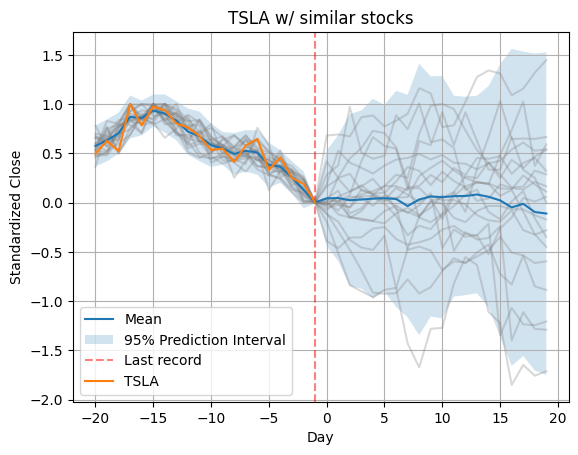

In [13]:
from matplotlib import pyplot as plt

from stock_gone_wrong.simularity.preprocess import extended_minmax_scale
from stock_gone_wrong.simularity.visual import calculate_PI, format_plot

similar_tickers = [data_pack.meta.loc[i]["Ticker"] for i in idx]
print(sorted(list(set(similar_tickers))))

x_days = np.arange(-DAYS_WINDOW, DAYS_WINDOW)
scaled_series = []
for i in idx:
    series = data_pack.get_series(i, METRICS, DAYS_WINDOW * 2)
    series = extended_minmax_scale(series, (0, 1), fit_window=slice(0, DAYS_WINDOW))
    plt.plot(x_days, series, color="grey", alpha=0.3)
    scaled_series.append(series)
scaled_data = np.stack(scaled_series)


if SHOW_FORECAST:
    series_mean = scaled_data.mean(axis=0)
    plt.plot(x_days, series_mean, label="Mean")
    pi_lower, pi_upper = calculate_PI(scaled_data)
    plt.fill_between(
        x_days, pi_lower, pi_upper, alpha=0.2, label="95% Prediction Interval"
    )
plt.axvline(-1, color="red", alpha=0.5, linestyle="--", label="Last record")
plt.plot(x_days[:DAYS_WINDOW], query_data[0], label=TICKER)

format_plot(TICKER, METRICS)
plt.show()